In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model

import os, json

from keras.layers import Input
from keras.optimizers import SGD, RMSprop, Adam
from enum import Enum
from keras.layers.core import Dense


Using TensorFlow backend.


## Create a model ready to fine tune

In [2]:
class BaseModels(Enum):
    inception = "InceptionV3"
    vgg = "VGG16"
output_classes = ["one", "ten"]
??VGG16

In [3]:
base_model = VGG16(include_top=True, weights='imagenet') ## functional API

In [4]:
## replaces last dense layer with another dense layer of size the number of classes
x = base_model.layers[-2].output ## output is prior to last output
predictions = Dense(len(output_classes), activation='softmax', name = "predictions")(x)
ft_model = Model(input=base_model.input, output=predictions)

## Freezes all but last layers
for layer in ft_model.layers:
    layer.trainable = False

## Make the last 2 dense layers trainable
for layer in ft_model.layers[-1:]:
    layer.trainable = True

ft_model.compile(optimizer=SGD(lr=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])



In [5]:
ft_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Getting training data

In [6]:
%matplotlib inline
path = "/srv/"

import utils; reload(utils)
from utils import plots
from keras.preprocessing import image
import numpy as np


### Get batch data

In [7]:
batch_size=8

In [8]:
def get_batches(path, shuffle=True, batch_size=8, class_mode='categorical'):
        ## option 1 - no image augmentation
        data_augmentation = False
        if data_augmentation:
            gen=image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True, vertical_flip=True, dim_ordering='tf')
        else:
            gen=image.ImageDataGenerator(dim_ordering='tf')


        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [9]:
batches = get_batches(path+'training', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 724 images belonging to 2 classes.
Found 179 images belonging to 2 classes.


### Train

In [10]:
ft_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
724/724 [==============================] - 870s - loss: 0.2700 - acc: 0.8923 - val_loss: 0.0760 - val_acc: 0.9944

In [11]:
ft_model.save(path+"ft_model.h5")

### Test

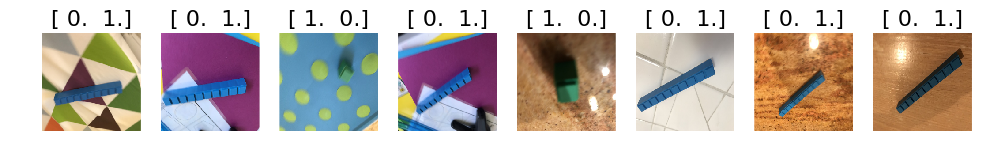

In [12]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [13]:
predictions = ft_model.predict(imgs)
idxs = np.argmax(predictions, axis=1)
# get the values of the highest probability for each image
preds = [predictions[i, idxs[i]] for i in range(len(idxs))]
pred_classes = [output_classes[idx] for idx in idxs]


In [14]:
print preds, pred_classes

[0.96552646, 0.99862325, 0.98411167, 0.90069962, 0.99750012, 0.99850571, 0.9981249, 0.99993598] ['ten', 'ten', 'one', 'ten', 'one', 'ten', 'ten', 'ten']


## CoreML Conversion

In [15]:
import coremltools

In [16]:
from keras.models import load_model
ft_model = load_model(path+"ft_model.h5")



In [17]:
coreml_model = coremltools.converters.keras.convert(ft_model, input_names = 'image', image_input_names = 'image', class_labels = output_classes, is_bgr=True, red_bias=-123.68, green_bias=-116.78, blue_bias=-103.94)

unfiltered shape
(None, 224, 224, 3)
printing input features from keras converter
[('image', Array({3,224,224}))]
0 : input_1, <keras.engine.topology.InputLayer object at 0x7f06e2ad5150>
1 : block1_conv1, <keras.layers.convolutional.Convolution2D object at 0x7f06e2ad5490>
2 : block1_conv1__activation__, <keras.layers.core.Activation object at 0x7f06e2ac07d0>
3 : block1_conv2, <keras.layers.convolutional.Convolution2D object at 0x7f06e2ad5510>
4 : block1_conv2__activation__, <keras.layers.core.Activation object at 0x7f06e2ac0710>
5 : block1_pool, <keras.layers.pooling.MaxPooling2D object at 0x7f06e2ad5550>
6 : block2_conv1, <keras.layers.convolutional.Convolution2D object at 0x7f06e2a31a90>
7 : block2_conv1__activation__, <keras.layers.core.Activation object at 0x7f06e2ac0690>
8 : block2_conv2, <keras.layers.convolutional.Convolution2D object at 0x7f06e2aa30d0>
9 : block2_conv2__activation__, <keras.layers.core.Activation object at 0x7f06e4213a50>
10 : block2_pool, <keras.layers.pooling

In [19]:
coreml_model.short_description = 'Categorize within 1 or 10 math-u-see blocks - 3 epochs'

In [20]:
coreml_model.save(path+"vgg_image.mlmodel")